In [13]:
import torch

print(torch.cuda.is_available())



True


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.mobile_optimizer import optimize_for_mobile
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image

# Crear el conjunto de datos
data_dir = "dataset"


training_dir = data_dir + "/training"
validation_dir = data_dir + "/validation"

## ResNet50

In [5]:
from torchvision.models import ResNet50_Weights

model_name = "resnet50"
# Initialize the Weight Transforms
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [6]:
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)


In [7]:
class_names = train_dataset.classes
print(class_names)

['anemona', 'barba_de_viejo', 'cachiyuyo', 'cadillo', 'calafate', 'canelo', 'chaura', 'flor_de_papel', 'frutilla_del_diablo', 'frutilla_silvestre', 'guindo', 'lenadura', 'lenga', 'maiten_enano', 'matanegra', 'michay', 'murtilla', 'nire', 'notro', 'orquidea_amarilla', 'palomita', 'parrilla', 'perezia_azul', 'punque', 'violeta_amarilla']


In [8]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /home/brigoni/.cache/torch/hub/main.zip
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/brigoni/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.fc = nn.Linear(2048, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 75

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, "resnet50.pt")


/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


epoch: 1 | train_acc: 0.3498 | val_acc: 0.4876 | loss 2.2988
epoch: 2 | train_acc: 0.6068 | val_acc: 0.6517 | loss 2.3291
epoch: 3 | train_acc: 0.6634 | val_acc: 0.6368 | loss 1.7508
epoch: 4 | train_acc: 0.6846 | val_acc: 0.6617 | loss 1.3681
epoch: 5 | train_acc: 0.7129 | val_acc: 0.7065 | loss 2.4914
epoch: 6 | train_acc: 0.7117 | val_acc: 0.6766 | loss 1.6361
epoch: 7 | train_acc: 0.7153 | val_acc: 0.6816 | loss 1.2245
epoch: 8 | train_acc: 0.7376 | val_acc: 0.6965 | loss 2.3657
epoch: 9 | train_acc: 0.7437 | val_acc: 0.6816 | loss 2.2531
epoch: 10 | train_acc: 0.7316 | val_acc: 0.7065 | loss 3.0026
epoch: 11 | train_acc: 0.7551 | val_acc: 0.6915 | loss 5.4395
epoch: 12 | train_acc: 0.7527 | val_acc: 0.7164 | loss 0.7003
epoch: 13 | train_acc: 0.7509 | val_acc: 0.7114 | loss 1.1594
epoch: 14 | train_acc: 0.7642 | val_acc: 0.7164 | loss 3.5737
epoch: 15 | train_acc: 0.7714 | val_acc: 0.7164 | loss 2.0433
epoch: 16 | train_acc: 0.7690 | val_acc: 0.7114 | loss 0.6436
epoch: 17 | train

In [10]:
# time: 75 epochs 192minutos

# Load the model
model = torch.load("resnet50.pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter("resnet50.ptl")

print("model successfully exported")

"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load("resnet50.pt")
backbone = backbone.to('cpu')
torch.save(backbone, "resnet50_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter("resnet50_cpu.ptl")

model successfully exported


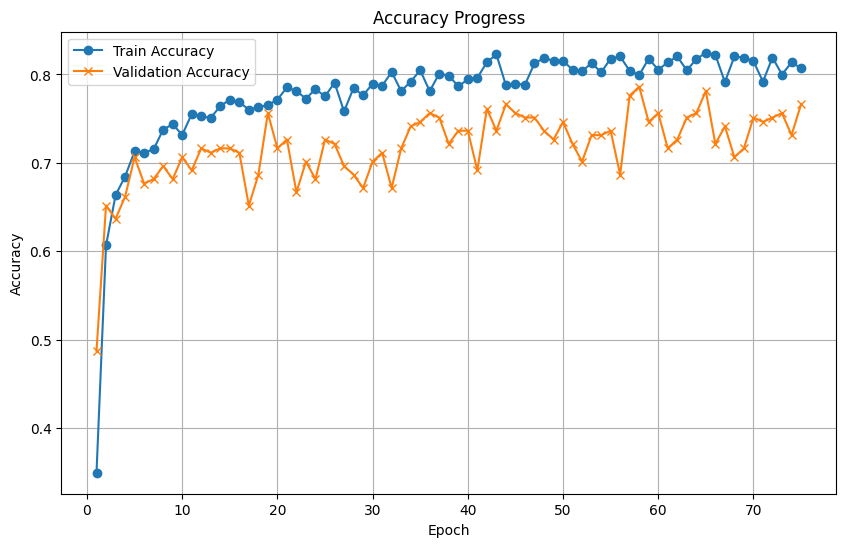

In [11]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


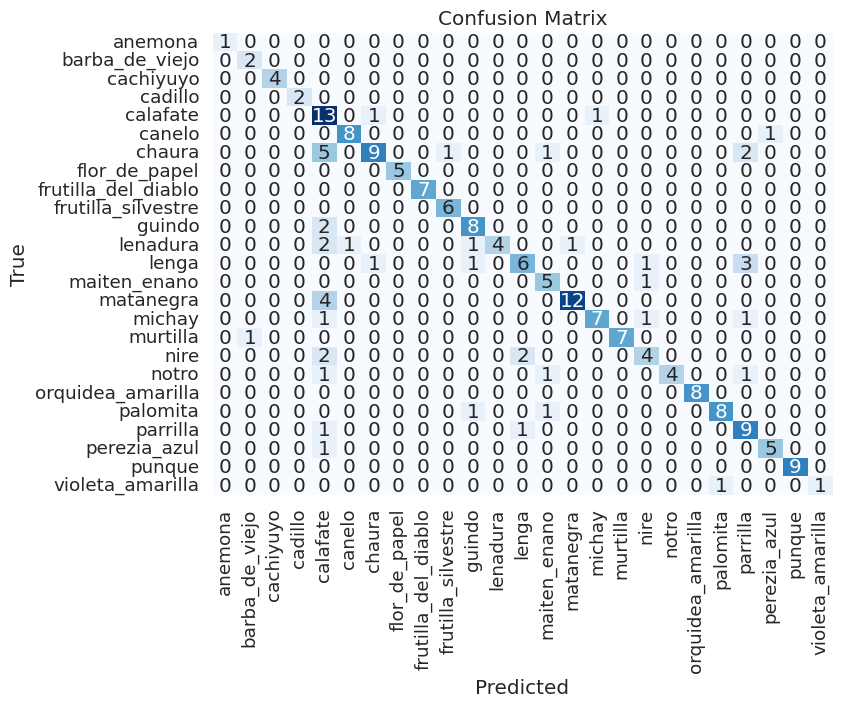

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       0.41      0.87      0.55        15
           5       0.89      0.89      0.89         9
           6       0.82      0.50      0.62        18
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         7
           9       0.86      1.00      0.92         6
          10       0.73      0.80      0.76        10
          11       1.00      0.44      0.62         9
          12       0.67      0.50      0.57        12
          13       0.62      0.83      0.71         6
          14       0.92      0.75      0.83        16
          15       0.88      0.70      0.78        10
          16       1.00      0.88      0.93         8
          17       0.57    

In [12]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


## MobileNetV3 Large

In [15]:
from torchvision.models import MobileNet_V3_Large_Weights

model_name = "mobilenet_v3_large"
# Initialize the Weight Transforms
weights = MobileNet_V3_Large_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [16]:
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)


class_names = train_dataset.classes
print(class_names)

['anemona', 'barba_de_viejo', 'cachiyuyo', 'cadillo', 'calafate', 'canelo', 'chaura', 'flor_de_papel', 'frutilla_del_diablo', 'frutilla_silvestre', 'guindo', 'lenadura', 'lenga', 'maiten_enano', 'matanegra', 'michay', 'murtilla', 'nire', 'notro', 'orquidea_amarilla', 'palomita', 'parrilla', 'perezia_azul', 'punque', 'violeta_amarilla']


In [17]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/brigoni/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100.0%


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[3] = nn.Linear(1280, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


In [ ]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")

In [ ]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


## MobileNetV3 Small

In [18]:
from torchvision.models import MobileNet_V3_Small_Weights

model_name = "mobilenet_v3_small"
# Initialize the Weight Transforms
weights = MobileNet_V3_Small_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [19]:
# check normalize with last cell
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.RandomResizedCrop((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)

class_names = train_dataset.classes
print(class_names)

['anemona', 'barba_de_viejo', 'cachiyuyo', 'cadillo', 'calafate', 'canelo', 'chaura', 'flor_de_papel', 'frutilla_del_diablo', 'frutilla_silvestre', 'guindo', 'lenadura', 'lenga', 'maiten_enano', 'matanegra', 'michay', 'murtilla', 'nire', 'notro', 'orquidea_amarilla', 'palomita', 'parrilla', 'perezia_azul', 'punque', 'violeta_amarilla']


In [20]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/brigoni/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100.0%


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[3] = nn.Linear(1024, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


In [ ]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")

In [ ]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


## EfficientNetV2 Large

In [21]:
from torchvision.models import EfficientNet_V2_L_Weights

model_name = "efficientnet_v2_l"
# Initialize the Weight Transforms
weights = EfficientNet_V2_L_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)


In [22]:
# check normalize with last cell
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.RandomResizedCrop((480, 480)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)

class_names = train_dataset.classes
print(class_names)

['anemona', 'barba_de_viejo', 'cachiyuyo', 'cadillo', 'calafate', 'canelo', 'chaura', 'flor_de_papel', 'frutilla_del_diablo', 'frutilla_silvestre', 'guindo', 'lenadura', 'lenga', 'maiten_enano', 'matanegra', 'michay', 'murtilla', 'nire', 'notro', 'orquidea_amarilla', 'palomita', 'parrilla', 'perezia_azul', 'punque', 'violeta_amarilla']


In [23]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /home/brigoni/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100.0%


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[1] = nn.Linear(1280, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


In [ ]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")


In [ ]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


## EfficientNetV2 Medium

In [24]:
from torchvision.models import EfficientNet_V2_M_Weights

model_name = "efficientnet_v2_m"
# Initialize the Weight Transforms
weights = EfficientNet_V2_M_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [25]:
# check normalize with last cell
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.RandomResizedCrop((480, 480)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)


class_names = train_dataset.classes
print(class_names)


['anemona', 'barba_de_viejo', 'cachiyuyo', 'cadillo', 'calafate', 'canelo', 'chaura', 'flor_de_papel', 'frutilla_del_diablo', 'frutilla_silvestre', 'guindo', 'lenadura', 'lenga', 'maiten_enano', 'matanegra', 'michay', 'murtilla', 'nire', 'notro', 'orquidea_amarilla', 'palomita', 'parrilla', 'perezia_azul', 'punque', 'violeta_amarilla']


In [26]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /home/brigoni/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100.0%


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[1] = nn.Linear(1280, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


In [ ]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")


In [ ]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))


## EfficientNetV2 Small

In [27]:
from torchvision.models import EfficientNet_V2_S_Weights

model_name = "efficientnet_v2_s"
# Initialize the Weight Transforms
weights = EfficientNet_V2_S_Weights.DEFAULT
preprocess = weights.transforms()

print(weights.transforms())

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [28]:
# check normalize with last cell
train_dataset = datasets.ImageFolder(data_dir + "/training", transforms.Compose([
    transforms.RandomResizedCrop((384, 384)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

validation_dataset = datasets.ImageFolder(data_dir + "/validation", transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True
)


In [29]:
# Crear el modelo
backbone = torch.hub.load('pytorch/vision', model_name, pretrained=True)
print(backbone)

Using cache found in /home/brigoni/.cache/torch/hub/pytorch_vision_main
/home/brigoni/Development/tesis/models/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /home/brigoni/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100.0%


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Congelar los parámetros preentrenados
for param in backbone.parameters():
    param.requires_grad = False

# Añadir una capa de clasificación
# fc es el nombre de la capa, que lo conocemos por haber impreso el modelo en
# el bloque anterior
backbone.classifier[1] = nn.Linear(1280, len(class_names))

# Optimizador
optimizer = optim.Adam(backbone.parameters())

# Función de pérdida
loss_function = nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 100

# Lists to store metrics
train_accuracy_history = []
validation_accuracy_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
backbone.to(device)

for epoch in range(num_epochs):

    # Train
    backbone.train()
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        loss = loss_function(predictions, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    train_accuracy_history.append(train_accuracy)

    # Validation
    backbone.eval()
    correct_validation = 0
    total_validation = 0
    for batch in validation_loader:
        images, labels = batch
        predictions = backbone(images.to(device))
        _, predicted = torch.max(predictions.data, 1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels.to(device)).sum().item()

    # Calculate validation accuracy
    validation_accuracy = correct_validation / total_validation
    validation_accuracy_history.append(validation_accuracy)

    # Print epoch metrics
    print("epoch: {} | train_acc: {:.4f} | val_acc: {:.4f} | loss {:.4f}".format(epoch + 1, train_accuracy, validation_accuracy, loss))


# Guardar el modelo
torch.save(backbone, model_name + ".pt")


In [ ]:
# Load the model
model = torch.load(model_name + ".pt")
model.eval()

scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(model_name + ".ptl")

print("model successfully exported")
"""
Issue on mobile detecting CUDA backend: ect {
  "message": "Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend
need to convert all operations in CPU mode
"""

device = torch.device("cpu")
backbone = torch.load(f"{model_name}.pt")
backbone = backbone.to('cpu')
torch.save(backbone, f"{model_name}_cpu.pt")

scripted_model_cpu = torch.jit.script(backbone)
optimized_model_cpu = optimize_for_mobile(scripted_model_cpu)
optimized_model_cpu._save_for_lite_interpreter(f"{model_name}_cpu.ptl")


In [ ]:
# Plot the accuracy progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# After training is complete, you can calculate the confusion matrix
backbone.eval()
all_labels = []
all_predictions = []

for batch in validation_loader:
    images, labels = batch
    predictions = backbone(images.to(device))
    _, predicted = torch.max(predictions.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for more details
print(classification_report(all_labels, all_predictions))
